In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pydicom as pdicom
import os
import pandas as pd
import numpy as np
from scipy.ndimage import rotate
from tqdm import tqdm

from PIL import Image
from collections import Counter, defaultdict
from natsort import natsorted

import keras
from keras.preprocessing.image import array_to_img

# from utils import clean_slice, sort_paths, rotate_side_lr, rotate_horisontally

Using TensorFlow backend.


In [2]:
#list all dicom images
dicom_path = "Dataset"
lstFilesDCM = []  # create an empty list
for dirName, subdirList, fileList in os.walk(dicom_path):
    for filename in fileList:
        if ".dcm" in filename.lower():  # check whether the file's DICOM
            lstFilesDCM.append(os.path.join(dirName,filename))
            #print(lstFilesDCM)
natsorted(lstFilesDCM)
print("Number of all files: ", len(lstFilesDCM))

ct_paths = []
for e in lstFilesDCM:
    if e.split('/')[-1][:2]=="CT":
        ct_paths.append(e)
        
print("Number of CT files: ", len(ct_paths))
    

Number of all files:  8122
Number of CT files:  2860


In [3]:
RefDs = pdicom.read_file(ct_paths[0])
print(RefDs)

# RefDsList = []
# for elem in ct_paths:
#     RefDsList.append(pdicom.read_file(elem))
    
# RefDsList

(0008, 0005) Specific Character Set              CS: 'ISO_IR 192'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'CT_SOM5 SPI']
(0008, 0012) Instance Creation Date              DA: '20181018'
(0008, 0013) Instance Creation Time              TM: '070123'
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.12.2.1107.5.1.4.65763.30000017071308013339600001230
(0008, 0020) Study Date                          DA: '20170713'
(0008, 0021) Series Date                         DA: '20170713'
(0008, 0022) Acquisition Date                    DA: '20170713'
(0008, 0023) Content Date                        DA: '20170713'
(0008, 0030) Study Time                          TM: '110508.577'
(0008, 0031) Series Time                         TM: '111434.29'
(0008, 0032) Acquisition Time                    TM: '111425.167'
(0008, 0033) Content Time                        TM: '111425.167'
(0008, 00

In [4]:
arr_shapes = []
d = dict()
# loop through all the DICOM files
for filenameDCM in tqdm(ct_paths):
    if "Image" not in filenameDCM:
        continue
    # read the file
    ds = pdicom.read_file(filenameDCM)
    arr_shapes.append(ds.pixel_array.shape)
    shape = ds.pixel_array.shape
    if shape in d.keys():
        d[shape].append(filenameDCM)
    else:
        d[shape] = [filenameDCM]
print(len(arr_shapes))
Counter(arr_shapes)

100%|██████████| 2860/2860 [00:13<00:00, 211.65it/s]

2860


Counter({(512, 512): 2860})

In [5]:
from typing import List
def sort_paths(paths: List[str]) -> List[str]:  
    """Augmented natural sorting to group together brain slices"""
    ct_paths_sorted = natsorted(paths)
    curr_patient_id = ct_paths_sorted[0].split('/')[-2]
    fst = []
    snd = defaultdict(list)
    ct_sorted = []
    for i in range(len(ct_paths_sorted)-1):
        patient_id = ct_paths_sorted[i].split('/')[-2]
        if patient_id!=curr_patient_id:
            ct_sorted += fst 
            for scan_id in sorted(snd.keys()):
                ct_sorted += snd[scan_id]
            fst = []
            snd = defaultdict(list)
            curr_patient_id = patient_id
            
        if '_' in ct_paths_sorted[i].split('/')[-1]:
            scan_id = ct_paths_sorted[i].split('/')[-1].split('_')[-1]
            snd[scan_id].append(ct_paths_sorted[i])
        else:
            fst.append(ct_paths_sorted[i])

    ct_sorted += fst
    for scan_id in sorted(snd.keys()):
        ct_sorted += snd[scan_id]

    return ct_sorted

ct_paths_sorted = sort_paths(d[(512,512)])

In [6]:
slice2brain_id = []
for e in ct_paths_sorted:
    slice2brain_id.append(e.split('/')[-2])
Counter(slice2brain_id)

Counter({'339663': 77,
         '345923': 72,
         '346231': 69,
         '351423': 170,
         '353891': 65,
         '354152': 75,
         '361113': 68,
         '362946': 65,
         '363578': 73,
         '363740': 69,
         '378104': 118,
         '379682': 386,
         '380225': 77,
         '380677': 61,
         '383593': 270,
         '385185': 71,
         '385948': 70,
         '386346': 76,
         '386348': 133,
         '386661': 71,
         '386662': 70,
         '386800': 82,
         '386801': 77,
         '387098': 66,
         '387295': 67,
         '387404': 66,
         '387607': 72,
         '387719': 74,
         '387722': 73,
         '388070': 76})

In [7]:
arr = np.zeros((512, 512, len(ct_paths_sorted)))

for i in tqdm(range(len(ct_paths_sorted))):
    ds = pdicom.read_file(ct_paths_sorted[i]) 
    arr[:, :, i] = ds.pixel_array 

len(arr)

100%|██████████| 2859/2859 [00:49<00:00, 57.38it/s] 


512

In [8]:
print(arr.dtype)
print(arr.shape)
print(np.max(arr))
print(np.min(arr))
print("mean: ", np.mean(arr))
print("n pixels less than 5: ", np.sum(arr<5))
print("n pixels more than 5: ", np.sum(arr>=5))
print("mean of pixels greater than 5: ", np.mean(arr[arr>5]))
# print("std of pixels greater than 5: ", np.std(arr[arr>5]))

float64
(512, 512, 2859)
8000.0
0.0
mean:  251.95584692059384
n pixels less than 5:  476731411
n pixels more than 5:  272738285
mean of pixels greater than 5:  754.4710159943102


<Figure size 432x288 with 0 Axes>

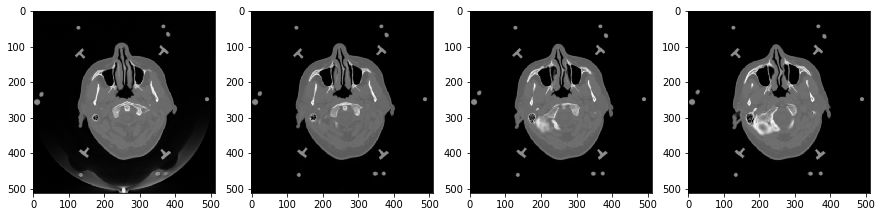

In [9]:
n_slices_to_plot = 4
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    plt.imshow(arr[:,:,i])
plt.show()

In [10]:
# im = array_to_img(ArrayDicom[:,:,1].reshape(512, 512, -1)) 
# IMG_SIZE = 224      

# new_size = tuple([int(x*(float(IMG_SIZE)/max(im.size))) for x in im.size])
# im_resized       = im.resize(new_size, Image.ANTIALIAS)
# new_im   = Image.new("L", (IMG_SIZE, IMG_SIZE))
# new_im.paste(im_resized, 
#              ((IMG_SIZE-new_size[0])//2,
#               (IMG_SIZE-new_size[1])//2))

# resized_image = np.array(new_im).reshape(224, 224, 1)
# array_to_img(resized_image) 

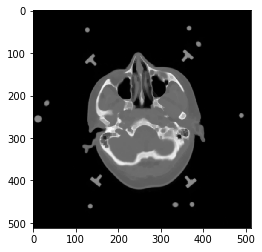

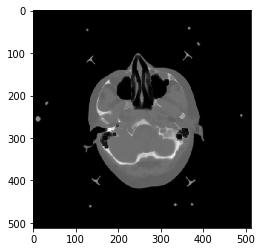

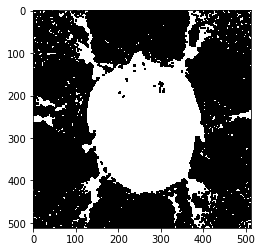

In [11]:
kernel = np.ones((5,5),np.uint8)
img = arr[:,:,7]
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
erode = cv2.erode(img, kernel, iterations = 1)
# dilation2 = cv2.dilate(closing,kernel,iterations = 1)
thres = erode>0
thres = np.array(thres, dtype=np.uint8)
plt.imshow(closing)
plt.show()
plt.imshow(erode)
plt.show()
plt.imshow(thres)

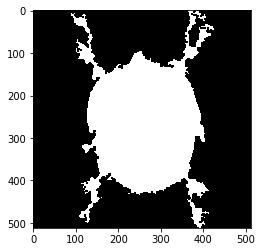

In [12]:
mask = np.zeros(img.shape,np.uint8)
imgg, contours, hier = cv2.findContours(thres,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
areas = []
for cnt in contours:
    areas.append(cv2.contourArea(cnt))

index = areas.index(max(areas))
cnt = contours[index]
mask = cv2.drawContours(mask,[cnt],0,255,-1)
plt.imshow(mask)

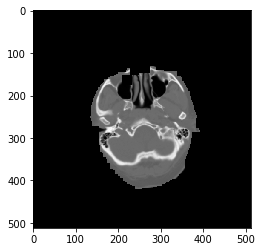

In [13]:
def clean_slice(img, erode_iter = 6, dilate_iter = 1):
    """
    too much noise remains -> increase erode_iter
    too little brain left -> increase dilate_iter
    returns 2D array
    
    """
    img = img.copy()
    kernel = np.ones((5,5),np.uint8)
    if len(img.shape)==3:
        img = img[:,:,0]
    img_morph = cv2.erode(img, kernel, iterations = erode_iter)
    thres = img_morph>0
    thres = np.array(thres, dtype=np.uint8)
    
    mask = np.zeros(thres.shape, np.uint8)
    imgg, contours, hier = cv2.findContours(thres,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)
    areas = []
    for cnt in contours:
        areas.append(cv2.contourArea(cnt))
        
    index = areas.index(max(areas))
    cnt = contours[index]
    mask = cv2.drawContours(mask,[cnt],0,255,-1)
    mask = cv2.dilate(mask, kernel,iterations = dilate_iter)
    mask = mask>1
    img[~mask] = 0
    
    return img

a= clean_slice(img)
plt.imshow(a)

<Figure size 432x288 with 0 Axes>

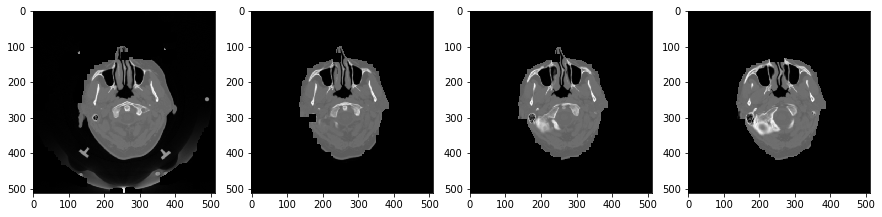

In [14]:
n_slices_to_plot = 4
n_rows = n_slices_to_plot // 4 + 1

plt.set_cmap(plt.gray())
fig = plt.figure(figsize=(15, 17))
for i in range(n_slices_to_plot):
    plt.subplot(n_rows, 4, i + 1)
    img = clean_slice(arr[:,:,i])
    plt.imshow(img)
plt.show()

In [120]:
def get_slice_index(ct_paths_sorted, verbose=False):
    j = 0
    brain_count = 0
    slice_index = []
    for i in range(len(ct_paths_sorted)-1):
        a = ct_paths_sorted[i].split("Image")[-1].split('.')[0].strip()
        b = ct_paths_sorted[i+1].split("Image")[-1].split('.')[0].strip()
        new_brain = '_' in b and '_' not in a
        if '_' in a:
            a = a.split('_')[-2]
        if '_' in b:
            b = b.split('_')[-2]
        a = int(a)
        b = int(b)
        if a>b or new_brain:
            if verbose:
                print("#"*12)
                print(ct_paths_sorted[i])
                print(ct_paths_sorted[i+1])
                print("number of slices: ", i-j)
            slice_index.append((j, i))
            j = i
            brain_count += 1
    if verbose:
        print("number of brain scans: ", brain_count)
    return slice_index

slice_index = get_slice_index(ct_paths_sorted, verbose=True)

############
Dataset/339663/CT.339663.Image 98.dcm
Dataset/345923/CT.345923.Image 1.dcm
number of slices:  76
############
Dataset/345923/CT.345923.Image 72.dcm
Dataset/346231/CT.346231.Image 1.dcm
number of slices:  72
############
Dataset/346231/CT.346231.Image 69.dcm
Dataset/351423/CT.351423.Image 2.dcm
number of slices:  69
############
Dataset/351423/CT.351423.Image 95.dcm
Dataset/351423/CT.351423.Image 4_0001.dcm
number of slices:  94
############
Dataset/351423/CT.351423.Image 79_0001.dcm
Dataset/353891/CT.353891.Image 5.dcm
number of slices:  76
############
Dataset/353891/CT.353891.Image 69.dcm
Dataset/354152/CT.354152.Image 5.dcm
number of slices:  65
############
Dataset/354152/CT.354152.Image 79.dcm
Dataset/361113/CT.361113.Image 5.dcm
number of slices:  75
############
Dataset/361113/CT.361113.Image 72.dcm
Dataset/362946/CT.362946.Image 5.dcm
number of slices:  68
############
Dataset/362946/CT.362946.Image 69.dcm
Dataset/363578/CT.363578.Image 6.dcm
number of slices:  65


In [16]:
def get_brain(scan_id, ct_paths_sorted, arr_all, slice_index=None):
    if slice_index is None:
        slice_index = get_slice_index(ct_paths_sorted)
        
    scan = arr_all[:, :, slice_index[scan_id][0]:slice_index[scan_id][1]]
    return scan

scan = get_brain(1, ct_paths_sorted, arr,)

In [17]:
def plot_slices(arr, n_slices_to_plot=4, offset=0, clean=False):
    n_rows = n_slices_to_plot // 4 + 1

    plt.set_cmap(plt.gray())
    fig = plt.figure(figsize=(15, 17))
    for i in range(n_slices_to_plot):
        plt.subplot(n_rows, 4, i + 1)
        img = arr[:,:,i+offset]
        if clean:
            img = clean_slice(img)
        plt.imshow(img)
    plt.show()

In [18]:
def rotate_scan(scan, angle, axes, keep_dim=True):
    s_rot = rotate(scan, angle, axes=axes)
    if keep_dim:
        shape = np.array(scan.shape)
        diff = np.array(s_rot.shape)-shape
        diff = diff//2
        end = shape+diff
        s_rot = s_rot[diff[0]:end[0], diff[1]:end[1], diff[2]:end[2]]
    return s_rot

def rotate_side_lr(scan, angle, keep_dim=True):
    return rotate_scan(scan, angle, (1,2))
    
def rotate_horisontally(scan, angle, keep_dim=True):
    return rotate_scan(scan, angle, (0,1))
    
s_rot = rotate_horisontally(scan, -20)
s_rot2 = rotate_side_lr(scan, 3)

<Figure size 432x288 with 0 Axes>

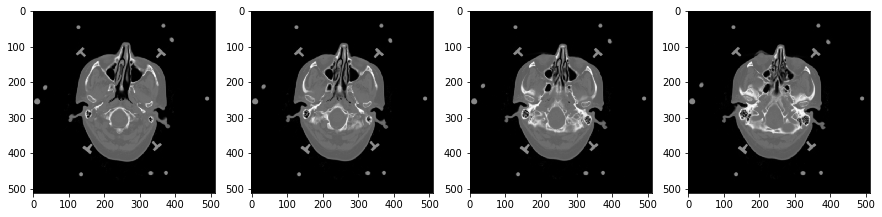

<Figure size 432x288 with 0 Axes>

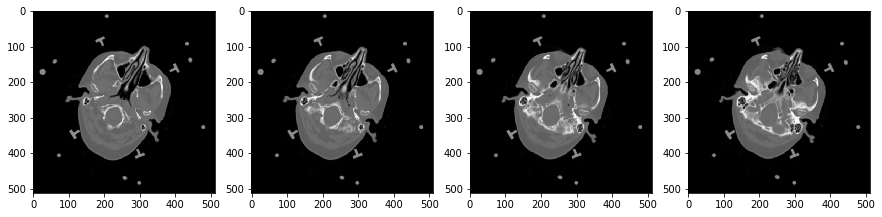

<Figure size 432x288 with 0 Axes>

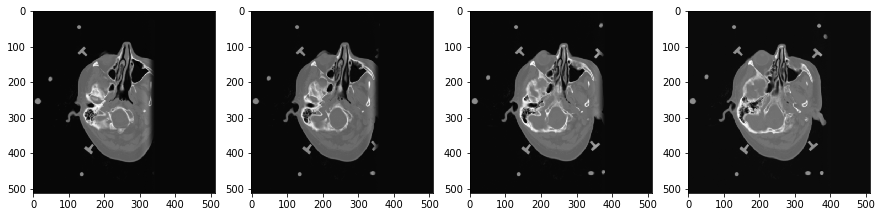

In [19]:
offset = 5
plot_slices(scan, offset=offset)
plot_slices(s_rot, offset=offset)
plot_slices(s_rot2, offset=offset)

In [20]:
np.max(s_rot2)

3372.264773808709

In [21]:
# scan
# rot_h = 1
# rot_h_best = 0
# rot_s = 0.3
# attemped_h = []
# max_rotation_tials = 5
# best = corr(scan)
# # best_param = dict()
# for i in range(max_rotation_tials):
#     rot_scan = rotate_horisontally(scan, rot_h+rot_h_best)
#     attemped_h.append(rot_h)
#     curr = corr(rot_scan)
#     if curr>best:
#         best = curr
# #         best_param["rot_h"] = rot_h
#         rot_h_best += rot_h
#     else:
#         if -rot_h in attemped_h:
#             rot_h = rot_h/10
#         else:
#             rot_h = -rot_h

<Figure size 432x288 with 0 Axes>

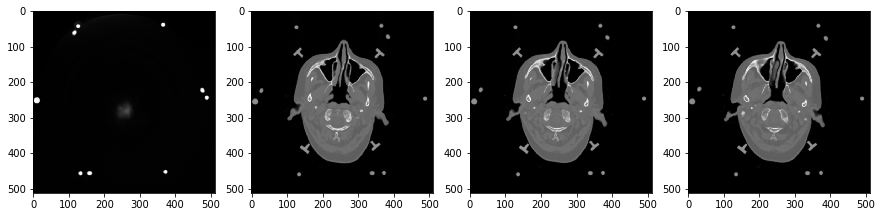

<Figure size 432x288 with 0 Axes>

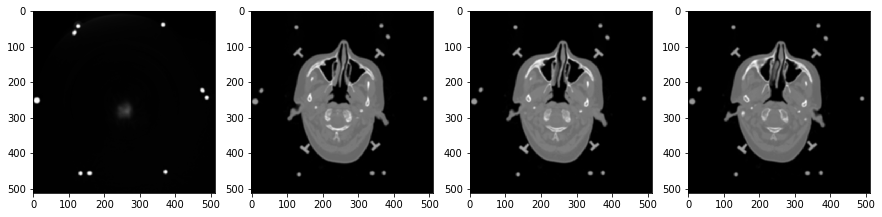

In [33]:
kernel_size = 5
blurred = cv2.blur(scan, (kernel_size, kernel_size))
plot_slices(scan)
plot_slices(blurred)

In [137]:
# scan[:, :, 22].shape

In [38]:
def findcorrandax(filenameDCM,axposition,padding,axcount,step):
    ds = pdicom.read_file(filenameDCM) 
    corr_coef=np.zeros(int(axcount))
    for k in range(0,int(axcount)):
        axplace=int(axposition-(axcount/2*step)+step*k)
        s=axplace-padding
        r=int(int(ds.pixel_array.shape[0])-(axplace+padding))
        lengthpic=2*int(np.minimum(s,r))
        firsthalf=np.zeros((ds.pixel_array.shape[0],int(lengthpic/2)))
        secondhalf=np.zeros((ds.pixel_array.shape[0],int(lengthpic/2)))
        second=np.zeros((ds.pixel_array.shape[0],int(lengthpic/2))) 
        for col in range(0,int(lengthpic/2)):
            firsthalf[:,col]= ds.pixel_array[:,col]
        for col in range(int(lengthpic/2),int(lengthpic-1)):
            second[:,int(col-int(lengthpic/2))]= ds.pixel_array[:,col]
        secondhalf=np.flip(second,1)
        corr_coef[k]=np.corrcoef(secondhalf.flatten(),firsthalf.flatten())[0,1]
    bestcorr=corr_coef.max()
    l=corr_coef.argmax()
    axplace=int(axposition-(axcount/2*step)+step*l)
    return bestcorr,axplace,corr_coef

In [126]:
def slice_corr(layer, mid_point=None, padding=20):
    slice_width = layer.shape[0]
    if mid_point is None:
        mid_point = slice_width//2

    halfwidth = (slice_width-2*padding)//2
    l = layer[:, mid_point-halfwidth:mid_point] 
    r = layer[:, mid_point:mid_point+halfwidth]
    r_fliped = np.flip(r, axis=1)
    
    corr_coef_flat = np.corrcoef(l.flatten(), r_fliped.flatten())[0,1]
#     corr_coef_pairwise = np.mean(np.corrcoef(l, r_fliped))

#     print(corr_coef_pairwise)
#     print(corr_coef_flat)
#     print(r_fliped.shape)
#     print(r.shape)
#     print(l.shape)
#     plt.imshow(l)
#     plt.show()
#     plt.imshow(r)
#     plt.show()
#     plt.imshow(r_fliped)
#     plt.show()

    return corr_coef_flat #, corr_coef_pairwise

def find_corr_ax(layer, max_shift=10, step=2, padding=20):
    slice_width = layer.shape[0]
    mid_point = slice_width//2
    corrs = []
    axes = np.arange(mid_point-max_shift, mid_point+max_shift, step)
    for ax in axes:
        corrs.append(slice_corr(layer, mid_point=ax, padding=padding))
    try:
        ind = corrs.index(np.max(corrs))
    except:
        return -1, -1
    bestcorr = corrs[ind]
    axplace = axes[ind]
    return bestcorr, axplace

def brain_corr(scan, max_shift=10, step=2, padding=20):
    corrs = []
    axes = []
    for i in range(scan.shape[2]):
        bestcorr, axplace = find_corr_ax(scan[:, :, i], max_shift=max_shift, step=step, padding=padding)
        corrs.append(bestcorr)
        axes.append(axplace)
        
    return corrs, axes

def brain_corr2(scan, max_shift=10, step=2, padding=20, n_slices=50):
    corrs = []
    axes = []
    v_step = scan.shape[2]/n_slices
    
    for i in [int(v_step*j) for j in range(n_slices)]:
        bestcorr, axplace = find_corr_ax(scan[:, :, i], max_shift=max_shift, step=step, padding=padding)
        corrs.append(bestcorr)
        axes.append(axplace)
        
    return corrs, axes

c = []
ii = []
slice_id = 14
for i in range(240,275,1):
#     print(i)
#     print(slice_corr(scan[:, :, 12], i))
    c.append((slice_corr(scan[:, :, slice_id], i),i))
    ii.append(i)

In [136]:
n_slices = 50
n_brains = len(slice_index)
corr_all = np.zeros([n_slices, n_brains])
for i in tqdm(range(n_brains)):
    scan = get_brain(i, ct_paths_sorted, arr, slice_index)
    corrs, axes = brain_corr2(scan,n_slices=n_slices)
    corr_all[:, i] = corrs
# corr_all


 33%|███▎      | 13/39 [00:58<01:56,  4.48s/it]/home/luk/.local/lib/python3.5/site-packages/numpy/lib/function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/home/luk/.local/lib/python3.5/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
100%|██████████| 39/39 [04:24<00:00,  5.34s/it]


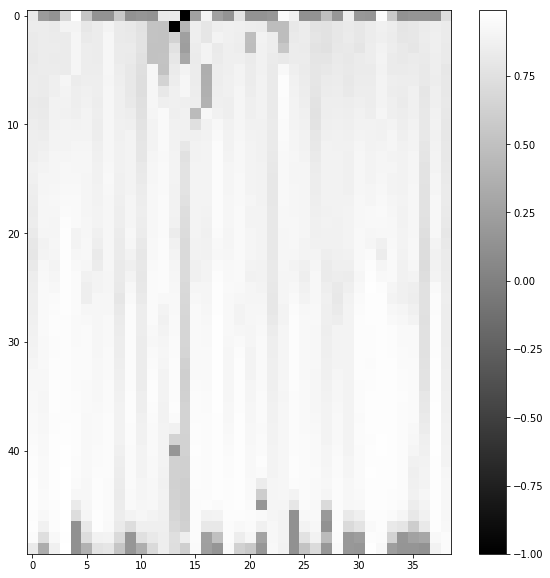

In [138]:
fig = plt.figure(figsize=(10, 10))
plt.imshow(corr_all)
plt.colorbar()

In [ ]:
# corr_all[10:40,:3]

# from now on it is very random!! may not work

In [104]:
find_corr_ax(scan[:, :, slice_id])

(0.8313887356335081, 246)

In [118]:
corrs, axes = brain_corr2(scan)
print(np.mean(corrs))
corrs

0.8673070376946939


[0.2082915173244833,
 0.8411328791006766,
 0.8349895446468805,
 0.8376887920721406,
 0.8410916936994309,
 0.8389832875962514,
 0.8168355816312706,
 0.8262683174300776,
 0.8313887356335081,
 0.8538197292710733,
 0.8773987902017829,
 0.8929568799576738,
 0.911375814074914,
 0.9132286509559113,
 0.9177926939407464,
 0.9159247057182235,
 0.889016277711273,
 0.8988914800732207,
 0.9259753022338535,
 0.9353736788048982,
 0.9370106607397202,
 0.9403352449856396,
 0.9387483881782333,
 0.9335864073976685,
 0.9317379418004068,
 0.9288729104318941,
 0.923457502527934,
 0.9210335169564584,
 0.9183663981275864,
 0.9234027332139446,
 0.9268690349920153,
 0.9317384509432429,
 0.9395940988095997,
 0.9405773747616404,
 0.9416220243187216,
 0.947635924109782,
 0.9324385555409438,
 0.8173420295581716,
 0.3421809206211642]

In [119]:
len(corrs)

39

In [112]:
rot_scan = rotate_horisontally(scan, 5)
corrs, axes = brain_corr(rot_scan)
print(np.mean(corrs))

0.8678050586876649


In [113]:
rot_scan = rotate_horisontally(scan, 2)
corrs, axes = brain_corr(rot_scan)
print(np.mean(corrs))

0.860941434604668


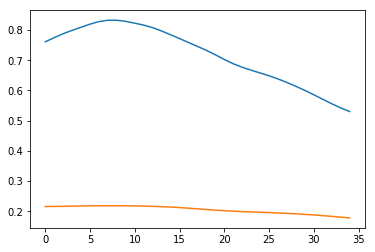

In [72]:
a = [e[0] for e in c]
b = [e[1] for e in c]

plt.plot(a)
plt.plot(b)

In [74]:
a.index(np.max(a))

7

In [75]:
b.index(np.max(b))

8

In [77]:
ii[8]

248

In [81]:
c

[((0.7613053342112246, 0.215571736946821), 240),
 ((0.7751119217383586, 0.21594078826373633), 241),
 ((0.7882264302128669, 0.21627710861299868), 242),
 ((0.7992742298799517, 0.2167895918987409), 243),
 ((0.809625107826444, 0.2174469265716417), 244),
 ((0.8198604762591547, 0.21796663182886516), 245),
 ((0.8283577949840248, 0.21806001775108444), 246),
 ((0.8327485501180014, 0.2181508630456235), 247),
 ((0.832685128822583, 0.21816395111759376), 248),
 ((0.828918916990057, 0.21809412777001297), 249),
 ((0.8229819063268903, 0.2178539092695582), 250),
 ((0.8165028083867225, 0.21714721383902943), 251),
 ((0.808244619106907, 0.21616470186553696), 252),
 ((0.7970325928475027, 0.21511773822478558), 253),
 ((0.7845884245331723, 0.21385741784784632), 254),
 ((0.7719146536462232, 0.21216967502412887), 255),
 ((0.7589945863907231, 0.21009693321901313), 256),
 ((0.7460398472268056, 0.20786809477630952), 257),
 ((0.7329347388433612, 0.20574173369855384), 258),
 ((0.7182971669389612, 0.2036888674760502

In [108]:
rot_scan = rotate_horisontally(scan, 1)
find_corr_ax(rot_scan[:, :, slice_id])

(0.8374114404427904, 246)

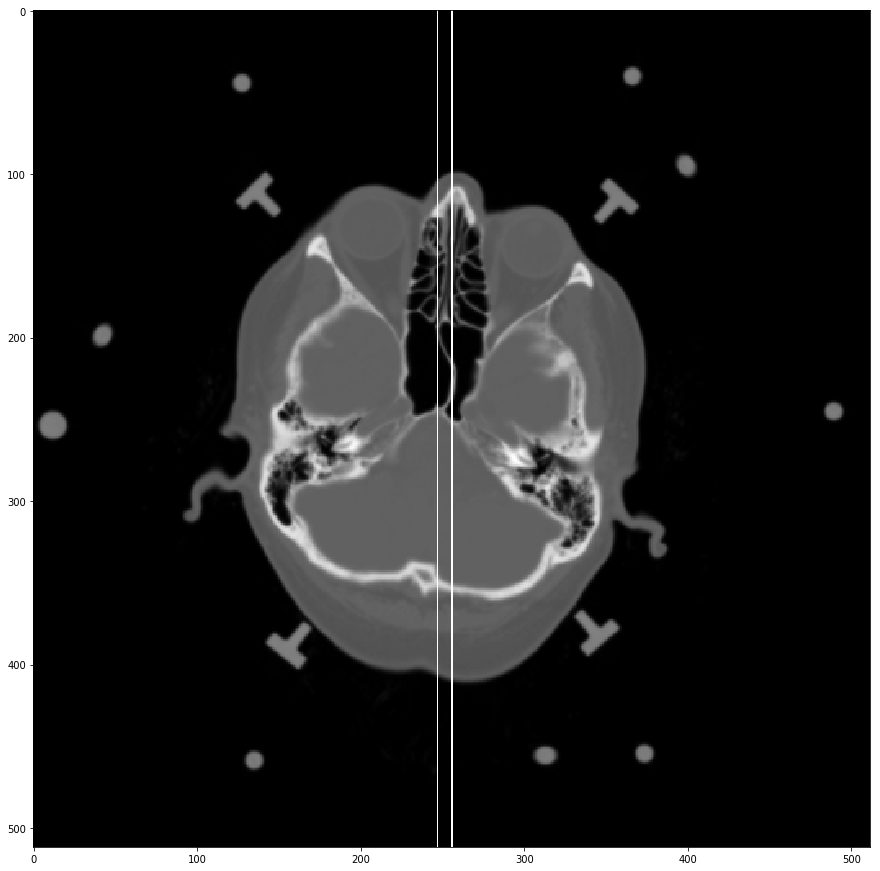

In [88]:
layer = scan[:, :, slice_id]
layer[:, 247] = np.max(layer)
layer[:, 256] = np.max(layer)

fig = plt.figure(figsize=(15, 17))
plt.imshow(layer)

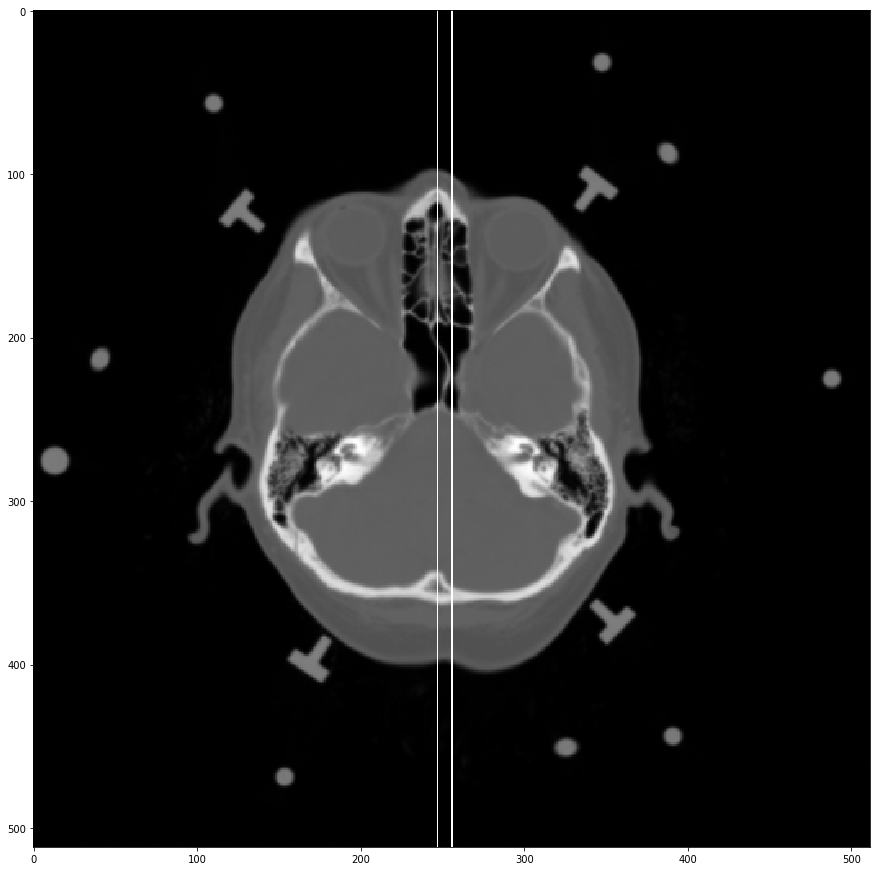

In [98]:
rot_scan = rotate_horisontally(scan, 5)
layer = rot_scan[:, :, slice_id]
layer = layer.copy()
layer[:, 247] = np.max(layer)
layer[:, 256] = np.max(layer)

fig = plt.figure(figsize=(15, 17))
plt.imshow(layer)

In [96]:
c = []
ii = []
slice_id = 14
for i in range(240,275,1):
#     print(i)
#     print(slice_corr(scan[:, :, 12], i))
    c.append((slice_corr(layer, i),i))
    ii.append(i)

(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)
(512, 236)

In [97]:
c

[((0.7694888147455486, nan), 240),
 ((0.786725417138861, nan), 241),
 ((0.8041287369121377, nan), 242),
 ((0.8230125518511548, nan), 243),
 ((0.8442598313973225, nan), 244),
 ((0.8669013423098657, nan), 245),
 ((0.8885782358947332, nan), 246),
 ((0.898942850280831, nan), 247),
 ((0.8893767986980496, nan), 248),
 ((0.8667510924033576, nan), 249),
 ((0.8418788021194847, nan), 250),
 ((0.8189855410765065, nan), 251),
 ((0.7997334245539895, 0.25551332208738475), 252),
 ((0.7836096057946822, 0.254507662481347), 253),
 ((0.7684751265823393, 0.2534698992460184), 254),
 ((0.7542963654162652, 0.25238836791527397), 255),
 ((0.7414375245703239, 0.25130730555721464), 256),
 ((0.7283507131783323, 0.25030767608437415), 257),
 ((0.7146876487191891, 0.2492041445483829), 258),
 ((0.7001486058858045, 0.247893257488517), 259),
 ((0.6856608994718085, 0.2467455362394698), 260),
 ((0.6717737097436969, 0.24546605426512347), 261),
 ((0.6595000894074037, 0.2441372988840602), 262),
 ((0.649248488907779, 0.24286